In [15]:
from modifinder.utilities.mol_utils import _get_molecules, get_modification_graph, _find_minimal_modification_edges_match, _get_edge_modifications
from rdkit import Chem
import modifinder.utilities.visualizer as vis

In [ ]:
mol1 = Chem.MolFromSmiles('Nc1c(O)cccc1C(=O)O')
mol2 = Chem.MolFromSmiles('COc1cc2c(c(NC(=O)CCC3CCCCC3)c1OC)C(=O)OC2')

annotated_mol1 = Chem.Mol(mol1)
annotated_mol2 = Chem.Mol(mol2)

for temp_mol in [annotated_mol1, annotated_mol2]:
    for atom in temp_mol.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))

In [6]:
main_struct = mol2
sub_struct = mol1
main_struct, sub_struct = _get_molecules(main_struct, sub_struct)
if not main_struct.HasSubstructMatch(sub_struct):
    if sub_struct.HasSubstructMatch(main_struct):
        # return get_modification_graph(sub_struct, main_struct)
        print("substructure is a substructure of the main structure")
    else:
        raise ValueError("One molecule should be a substructure of the other molecule")

atoms_of_substructure = _find_minimal_modification_edges_match(main_struct, sub_struct)
modificationEdgesOutward, modificationEdgesInside, noneModificationDifferentEdges = _get_edge_modifications(main_struct, sub_struct, atoms_of_substructure)

In [70]:
atoms_of_substructure

(7, 6, 18, 19, 2, 3, 4, 5, 21, 22, 23)

In [71]:
all_modification_edges = modificationEdgesOutward + modificationEdgesInside + noneModificationDifferentEdges
all_modification_edges

[(1, 2),
 (7, 8),
 (19, 20),
 (23, 24),
 (24, 4),
 (0, 1),
 (8, 9),
 (8, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 12)]

In [9]:
def dfs(mol, index, visited, color, all_modifications):
    if index in visited:
        return
    visited[index] = color
    
    for bond in all_modifications:
        if bond[0] == index:
            target = bond[1]
        elif bond[1] == index:
            target = bond[0]
        else:
            continue
        
        if target not in visited:
            dfs(mol, target, visited, color, all_modifications)
    return

visited = {}
color = 0
for atom in atoms_of_substructure:
    if atom not in visited:
        dfs(main_struct, atom, visited, color, all_modifications)
        color += 1

visited
        

{7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 6: 1,
 18: 2,
 19: 3,
 20: 3,
 2: 4,
 1: 4,
 0: 4,
 3: 5,
 4: 6,
 24: 6,
 23: 6,
 5: 7,
 21: 8,
 22: 9}

In [19]:
mol2.GetAtomWithIdx(1).GetNeighbors()

(<rdkit.Chem.rdchem.Atom at 0x7dfeacb67f20>,
 <rdkit.Chem.rdchem.Atom at 0x7dfeacb67dd0>)

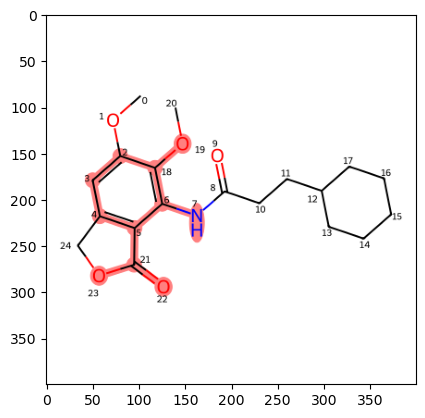

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(vis.draw_molecule(annotated_mol2, highlightAtoms=atoms_of_substructure))

In [100]:
atoms_of_substructure = _find_minimal_modification_edges_match(main_struct, sub_struct)
modificationEdgesOutward, modificationEdgesInside, noneModificationDifferentEdges = _get_edge_modifications(main_struct, sub_struct, atoms_of_substructure)
all_modification_edges = modificationEdgesOutward + modificationEdgesInside + noneModificationDifferentEdges

def dfs(mol, index, visited, color, all_modification_edges):
    if index in visited:
        return
    visited[index] = color
    
    for bond in all_modification_edges:
        if bond[0] == index:
            target = bond[1]
        elif bond[1] == index:
            target = bond[0]
        else:
            continue
        
        if target not in visited:
            dfs(mol, target, visited, color, all_modification_edges)
    return

visited = {}
color = 0
for atom in range(main_struct.GetNumAtoms()):
    if atom not in visited and atom not in atoms_of_substructure:
        dfs(main_struct, atom, visited, color, all_modification_edges)
        color += 1


all_modifications = []
for modification in range(color):
    true_map = dict()
    edit_mol = Chem.RWMol(main_struct)
    # delete any atom that is not in the modification
    for atom in range(main_struct.GetNumAtoms()-1, -1, -1):
        if atom not in visited or visited[atom] != modification:
            edit_mol.RemoveAtom(atom)
        elif atom in atoms_of_substructure:
            edit_mol.GetAtomWithIdx(atom).SetProp('atomNote', f'substructure_{atom}')
    
    new_edit_mol = Chem.RWMol()
    for atom in edit_mol.GetAtoms():
        try:
            note = atom.GetProp('atomNote')
        except:
            note = None
        if note is not None and note.startswith('substructure'):
            new_edit_mol.AddAtom(Chem.Atom(0))
            true_map[atom.GetIdx()] = note.split('_')[1]
        else:
            new_edit_mol.AddAtom(atom)
    
    for bond in edit_mol.GetBonds():
        new_edit_mol.AddBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())
        
    # new_edit_mol = new_edit_mol.GetMol()
    all_modifications.append((new_edit_mol, true_map, Chem.MolToSmarts(new_edit_mol)))
    
all_modifications

[(<rdkit.Chem.rdchem.RWMol at 0x7267882ca180>, {2: '2'}, '[#6]-[#8]-[#0]'),
 (<rdkit.Chem.rdchem.RWMol at 0x72678835abd0>,
  {0: '7'},
  '[#0]-[#6](=[#8])-[#6]-[#6]-[#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1'),
 (<rdkit.Chem.rdchem.RWMol at 0x7267882c5db0>, {0: '19'}, '[#0]-[#6]'),
 (<rdkit.Chem.rdchem.RWMol at 0x72678835a720>,
  {0: '4', 1: '23'},
  '[#0]-[#6]-[#0]')]

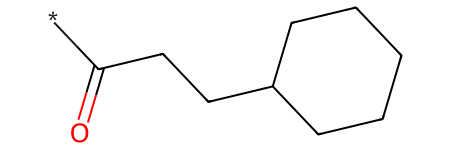

In [83]:
all_modifications[1][0]

In [101]:
wild_atom = list(all_modifications[1][1].keys())[0]
print(wild_atom)
neighbor = all_modifications[1][0].GetAtomWithIdx(wild_atom).GetNeighbors()[0]
print(neighbor)
bond_type = all_modifications[1][0].GetBondBetweenAtoms(wild_atom, neighbor.GetIdx()).GetBondType()
print(bond_type)
all_modifications[1][0].RemoveAtom(wild_atom)
print(neighbor.GetIdx())

frag = all_modifications[1][0]
index_in_frag = neighbor.GetIdx()
bondType = bond_type

0
SINGLE
0


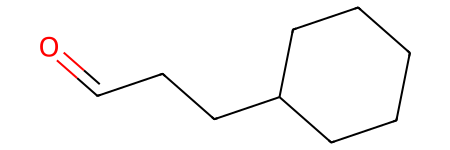

In [102]:
frag

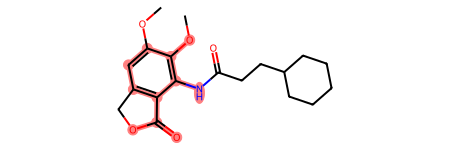

In [64]:
main_struct

In [63]:
smarts

['[#6]',
 '[#8]',
 '[#6]',
 '[#8]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]',
 '[#6]']

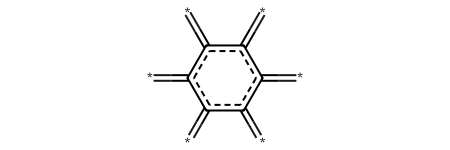

In [23]:
test_smarts = Chem.MolFromSmarts('*=c1:c(=*):c(=*):c(=*):c(=*):c:1=*')
test_smarts

In [24]:
test_smarts.GetNumAtoms()

12

In [34]:
for atom in test_smarts.GetAtoms():
    print(atom.GetSymbol(), atom.GetIdx(), atom.GetAtomicNum())

* 0 0
C 1 6
C 2 6
* 3 0
C 4 6
* 5 0
C 6 6
* 7 0
C 8 6
* 9 0
C 10 6
* 11 0


In [38]:
atom = Chem.rdchem.Atom(0).GetSymbol()
atom

'*'